<a href="https://colab.research.google.com/github/IMonukushwaha/COVID-19-Chest-X-Ray-Classification-using-CNN/blob/main/covid_detection_model27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [2]:
mouting_drive = '/content/drive'
from google.colab import drive
drive.mount(mouting_drive)

Mounted at /content/drive


In [3]:
import os
import shutil
import random

In [4]:
from keras.preprocessing import image_dataset_from_directory

In [5]:
PATH = '/content/drive/MyDrive/IMp_documents/archive (2)'
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [6]:
dataset = image_dataset_from_directory(
    PATH + '',
    seed = 42,
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6920 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['covid', 'normal', 'pneumonia']

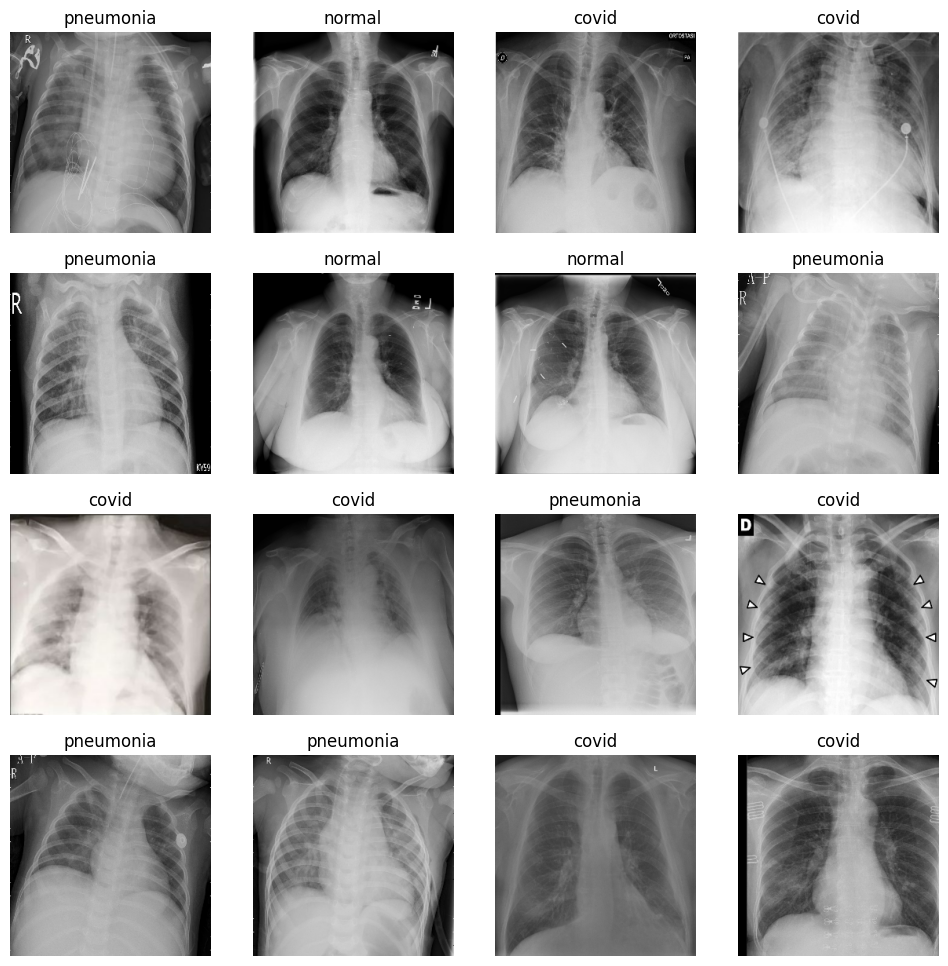

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [9]:
train_size = 0.8
validation_size = 0.2

In [10]:
# spliting the dataset in train_ds and val_ds -> take the first 80% dataset as train_ds and next 20% as val_ds,
# thats why the dataset is shuffled during loading from directory so to introduce randomness in training and vlaidation data.
train_batch = int(len(dataset) * train_size)
train_ds = dataset.take(train_batch)
val_batch = int(len(dataset) * validation_size)
val_ds = dataset.skip(train_batch).take(val_batch)

In [11]:
len(train_ds) # No of batches in train_ds

173

In [12]:
len(val_ds) # No. of batches in val_Ds

43

In [13]:
# preocessing the dataset images
from keras.applications.resnet50 import preprocess_input

def process_image(image, label):
  image = preprocess_input(image)
  return image, label

train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)

In [14]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
train_ds.element_spec
val_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [16]:
#data augmentation
from keras import layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
])

In [17]:
from keras.applications.resnet50 import ResNet50

In [18]:
#Loaded ResNet50 as a frozen “feature extractor” trained on ImageNet, ready to be adapted for new task.
Resnet_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
    )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [19]:
Resnet_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
Resnet_base.trainable = True

for layer in Resnet_base.layers[:-40]:
    layer.trainable = False

for layer in Resnet_base.layers:
  print(layer.name, layer.trainable)

input_layer False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2

In [21]:
from keras.layers import Reshape, GRU, GlobalAveragePooling2D, Dropout

In [22]:
from keras.src.regularizers import L2
from keras.src.regularizers.regularizers import L1
model = Sequential()
model.add(data_augmentation)
model.add(Resnet_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.7))
model.add(Dense(3, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 15,831,808 (60.39 MB)

 Non-trainable params: 7,755,904 (29.59 MB)

In [24]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7
)

In [ ]:
history = model.fit(train_ds,
                    batch_size=32,
                    epochs=60,
                    validation_data=val_ds,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1
                    )

Epoch 1/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 1347s 8s/step - accuracy: 0.7585 - loss: 0.8547 - val_accuracy: 0.9244 - val_loss: 0.5106 - learning_rate: 1.0000e-04
Epoch 2/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 160s 929ms/step - accuracy: 0.9164 - loss: 0.5017 - val_accuracy: 0.9041 - val_loss: 0.5352 - learning_rate: 1.0000e-04
Epoch 3/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 198s 906ms/step - accuracy: 0.9328 - loss: 0.4587 - val_accuracy: 0.8881 - val_loss: 0.5909 - learning_rate: 1.0000e-04
Epoch 4/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 158s 916ms/step - accuracy: 0.9406 - loss: 0.4214 - val_accuracy: 0.9477 - val_loss: 0.4116 - learning_rate: 1.0000e-04
Epoch 5/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 201s 911ms/step - accuracy: 0.9389 - loss: 0.4213 - val_accuracy: 0.9251 - val_loss: 0.4600 - learning_rate: 1.0000e-04
Epoch 6/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 158s 912ms/step - accuracy: 0.9495 - loss: 0.3768 - val_accuracy: 0.9121 - val_loss: 0.5567 - learning_rate: 1.0000e-04
Epoch 7/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 16

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy', color='red')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()